# Introduction to Dynamical Systems and Chaos

## Section 2

### Calculus Refresher

The derivative is the instantaneous rate of change of $x$ with regard to $t$:

In [1]:
'diff(x, t);

                                      dx
(%o2)                                 --
                                      dt

This is also the slope of $x(t)$.

### Introducing Differential Equations

Comparing iterated functions $x_{n+1} = f(x_n)$ to differential equations $\frac {d x}{d t} = f(x)$. 

In the former, if you tell me $x_n$, I can tell you the next $n$. You need a seed, and from that you can figure out the orbit.

In the latter, if you tell me $f(x)$, I can tell you how fast $x$ is changing. For a differential equation, you need an initial condition, and then you figure out the solution that is a continuous function.

#### Example: Newton's Law of Cooling

##### Euler's Method

The steps for Euler's method are, for a step size of 2:

$X(0) = x_0 = 5$ with $rate = (20 - 5)/5 = 3$

$X(0 + 2) = x_2 = 5 + 3 * 2 = 11$ with $rate = (20 - 11)/5 =  1.8$

$X(2 + 2) = x_4 = 11 + 1.8 * 2 = 14.6$ with $rate = (20 - 14.6)/5 = 1.08$

$X(4 + 2) = x_6 = 14.6 + 1.08 * 2 = 16.76$ with $rate = (20 - 16.76)/5 = 0.648$


In [2]:
to_lisp()$


Type (to-maxima) to restart, ($quit) to quit Maxima.


Let's generalize our steps above into a set of Lisp functions:

In [3]:
(defun points->maxima (data)
  (cons '(mlist) 
        (map 'list (lambda (x) `((mlist) ,@x)) data)))

(defun approx (xn step-size last-rate)
  (+ xn (* last-rate step-size)))

(defun $euler_method (func x0 step-size max-x)
  (labels ((e0 (acc)
    (let* ((step (length acc))
           (last-point (last acc))
           (this-x (caar last-point)))
      (if (>= this-x max-x) 
        (points->maxima acc)
        (let* ((args (cdar last-point))
               (rate (apply func args))
               (xn (approx (car args) step-size rate)))
          (e0 (append acc `((,(* step step-size) ,xn)))))))))
   (e0 `((0 ,x0)))))
  
(defun $cooling (y)
  (float (/ (- 20 y) 5)))

POINTS->MAXIMA

APPROX

$EULER_METHOD

$COOLING

In [4]:
(to-maxima)

Returning to Maxima


With a generalized function for Euler's Method, we can create data sets using finer steps:

In [5]:
xy0: euler_method(cooling, 5, 2, 20);
xy1: euler_method(cooling, 5, 1, 20)$
xy2: euler_method(cooling, 5, 0.5, 20)$

(%o4) [[0, 5], [2, 11.0], [4, 14.6], [6, 16.76], [8, 18.056], [10, 18.8336], 
[12, 19.30016], [14, 19.580096], [16, 19.7480576], [18, 19.84883456], 
[20, 19.909300736]]

The data sets get progressively larger, so we just showed the first one, above.

Here's a plot of these approximations:

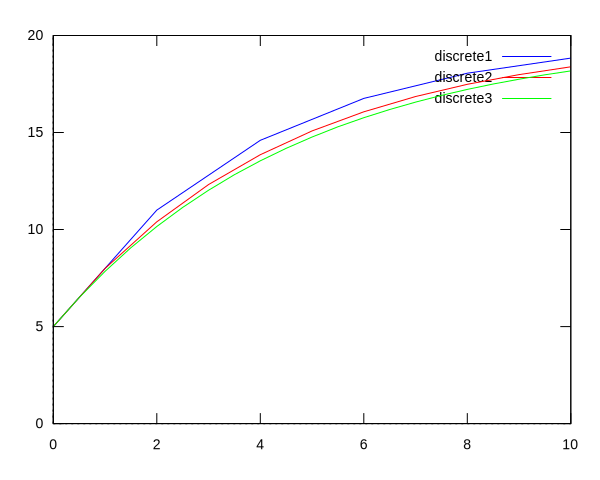

In [6]:
set_plot_option([svg_file, "maxplot.svg"])$
plot2d([[discrete,xy0],
        [discrete,xy1],
        [discrete,xy2]], [x, 0, 10], [y, 0, 20])$

##### Maxima Numerical Solution

Let's use Maxima's `ic1` (stands for "initial condition, first order differential equation") function to solve this differential equation:

In [7]:
eq:'diff(y, x) = 1/5 * (20 - y);

                                  dy   20 - y
(%o9)                             -- = ------
                                  dx     5

In [8]:
ode2(eq, y, x);

                                - x/5       x/5
(%o10)                    y = %e      (20 %e    + %c)

In [9]:
sol: ic1(%, x= 0, y= 5);

                                - x/5       x/5
(%o11)                    y = %e      (20 %e    - 15)

Here's a plot of the general solution:

plot2d: some values were clipped.


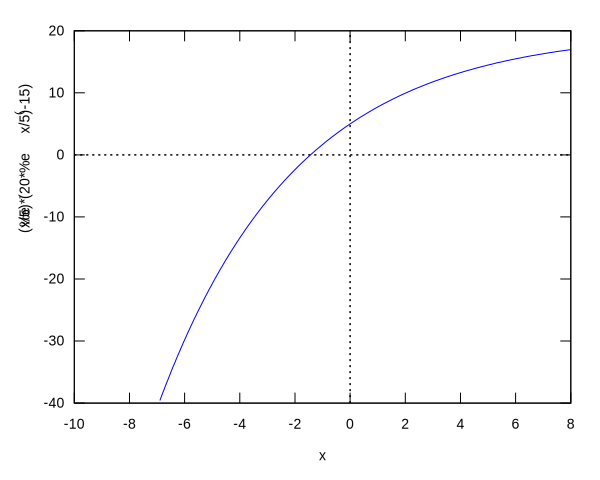

In [10]:
plot2d(rhs (sol), [x,-10,8], [y,-40,20])$

Let's use this solution to compare some values with our Euler's method approximation:

In [11]:
ic1_vals: map(lambda([s], float(ev(rhs(sol), x=s))), [0,2,4,6,8,10,12]);
approx_vals: map(second, firstn(xy0, 8));

(%o13) [5.0, 9.945199309465412, 13.26006553824168, 15.48208682131697, 
                       16.97155223008017, 17.96997075145081, 18.63923070065881]

(%o14)   [5, 11.0, 14.6, 16.76, 18.056, 18.8336, 19.30016, 19.580096]

In [12]:
to_lisp()$


Type (to-maxima) to restart, ($quit) to quit Maxima.


Let's look at the differences between the two outputs above (element-wise). To be clear, this will show how far off the approximate result is from the Maxima ODE numerical solution result. 

First we'll define some helper functions in Lisp, then we'll use those to create a function that actually computes the differences.

In [13]:
(defun maxima-> (data)
  "Quick little utility function that converts Maxima `mlist`s to a regular Lisp list."
  (cdr data))
  
(defun interleave (data1 data2)
  "Given two lists, combine them returning a list wHere the elements are alternated such
  that the first two elements are the first element of `data1` and `data2`, respectively;
  the next two elements are the second element of `data1` and `data2`, etc."
  (if (and (not (null data1)) (not (null data2)))
    (cons (car data1) (cons (car data2)
                            (interleave (cdr data1) (cdr data2))))))

(defun group-n (data count)
  "Given a list of elements, group them into sublists, each of length `count`. For example,
  a list of 10 elements passed with `count` equal to `2` will be returned as a list of 
  five elements, where each of those is two elements long. Similarly, that same list 
  passed with a count of `5` would return a list of two elements where each element was a
  sublist five elements (representing the first five elements of the original list in the
  first sublist and the last five elements of the original list in the second sublist)."
  (if (not (null data))
    (cons (subseq data 0 count)
          (group-n (subseq data count) count))))

(defun $get_differences (data1 data2)
  "Given two lists, pair each element of the two lists together, then subtract the 
  second element of each pair from the first element of each pair, returning a list
  of floating point numbers that represent the difference between corresponding 
  values.
  
  This function is indented to be run from Maxima, taking Maxiam-style lists as 
  arguments."
  (cons '(mlist)
        (mapcar (lambda (x) (apply #'- x)) 
                (group-n (interleave (maxima-> data1) (maxima-> data2)) 2))))

MAXIMA->

INTERLEAVE

GROUP-N

$GET_DIFFERENCES

In [14]:
(to-maxima)

Returning to Maxima


Now we can do the actual calculation to see how much the approximation differs from the actual solution:

In [15]:
get_differences(approx_vals, ic1_vals);

(%o16) [0.0, 1.054800690534588, 1.339934461758324, 1.277913178683031, 
                      1.08444776991983, 0.8636292485491843, 0.6609292993411842]

Now let's compare the solution above with our approximations from Eurler's method:

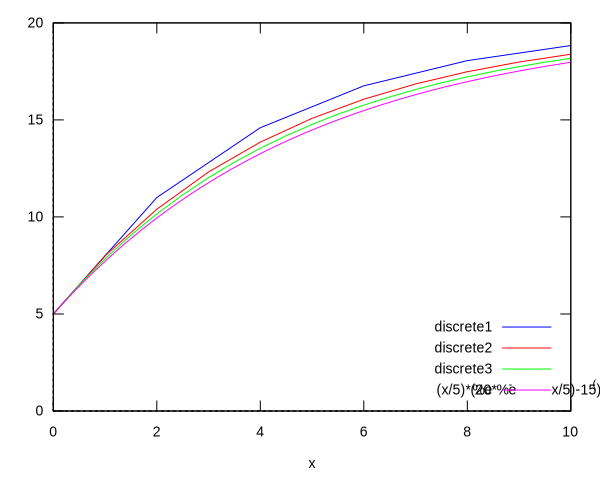

In [16]:
set_plot_option([svg_file, "maxplot.svg"])$
plot2d([[discrete,xy0],
        [discrete,xy1],
        [discrete,xy2],
        rhs (sol)], [x, 0, 10], [y, 0, 20],[gnuplot_preamble, "set key bottom right"])$